In [1]:
# import libs
%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# import datasets
mnist = fetch_openml('mnist_784')

In [3]:
# define input and output
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None,28,28,1],name = 'x') # input
    y = tf.placeholder(tf.float32,[None,10],name = 'y') # output

In [4]:
# a module
def get_weight(shape):
    w_init = tf.random.truncated_normal(shape = shape,mean=0,stddev=0.1)
    b_init = tf.random.truncated_normal(shape = [shape[-1]],mean=0,stddev=0.1)
    
    w = tf.Variable(initial_value = w_init)
    b =  tf.Variable(initial_value = b_init)
    return w,b

In [5]:
# 01
# define train variable
w1,b1 = get_weight([5,5,1,6]) 
# define cacu
o1 = tf.nn.conv2d(input = x,filter=w1,strides=[1,1,1,1],padding='SAME')
o1 = tf.nn.bias_add(o1,b1)
o1 = tf.nn.relu(o1)
o1 = tf.nn.avg_pool(value=o1, ksize=(1,2,2,1), strides=[1,2,2,1],padding='SAME')

In [6]:
# 02
# define train variable
w2,b2 = get_weight([5,5,6,16]) 
# define cacu
o2 = tf.nn.conv2d(input = o1,filter=w2,strides=[1,1,1,1],padding='VALID')
o2 = tf.nn.bias_add(o2,b2)
o2 = tf.nn.relu(o2)
o2 = tf.nn.avg_pool(value=o2, ksize=(1,2,2,1), strides=[1,2,2,1],padding='SAME')

In [7]:
# 03
# define train variable
w3,b3 = get_weight([5,5,16,120]) 
# define cacu
o3 = tf.nn.conv2d(input = o2,filter=w3,strides=[1,1,1,1],padding='VALID')
o3 = tf.nn.bias_add(o3,b3)
o3 = tf.nn.relu(o3)
o3 = tf.nn.avg_pool(value=o3, ksize=(1,2,2,1), strides=[1,2,2,1],padding='SAME')

In [8]:
# 2d->1d
o3 = tf.reshape(o3,[-1,120])
w4, b4 = get_weight([120,84])
o4 = tf.nn.relu(tf.matmul(o3,w4)+b4)

o4 = tf.nn.dropout(o4,0.75)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
w5, b5 = get_weight([84,10])
with tf.name_scope('prediction'):
    o5 = tf.nn.softmax(tf.matmul(o4,w5)+b5,name='output')
y_ = o5

In [10]:
#define loss function
loss = tf.losses.sigmoid_cross_entropy(y,y_)
optimzer = tf.train.AdamOptimizer(0.0001)
trainer = optimzer.minimize(loss)

In [11]:
# load data

# load label
result  = mnist.target
result = result[:10000]

labels = np.zeros(  (len(result),10),  dtype = np.int)
for i in range(len(result)):
    lb = int(result[i])
    labels[i][lb] = 1


#load image
data = np.zeros( (len(result),28,28,1),np.float32)

mnist_image = mnist.data

# show number image
#plt.imshow(mnist_image[1].reshape(28,28),cmap = 'gray')
#plt.show()
for i in range(len(result)):
    data[i,:,:,0] = mnist_image[i].reshape(28,28)
print("data loaded")

data loaded


In [12]:
# caculate accuracy rate
with tf.name_scope('accuracy'):
    correct = tf.equal(tf.argmax(y_,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct,'float') ,name='accuracy')

# train
session = tf.Session()
global_v = tf.global_variables()
op_init = tf.initializers.variables(global_v)
session.run(op_init)

TIMES = 100
batch_size  = 100
batch = len(data) // batch_size
correct_rates = []
for t in range(TIMES):
    loss_result = 0.0
    for idx in range(batch):
        _, loss_result = session.run(
            [trainer,loss],
            feed_dict={
                x:data[idx*batch_size:(idx+1)*batch_size],
                y:labels[idx*batch_size:(idx+1)*batch_size]
            }
        )
    correct_rate = session.run(accuracy,feed_dict={x:data,y:labels})
   # print("correct rate: %5.2f%% loss:%f" % (correct_rate*100.0, loss_result))
    correct_rates.append(correct_rate)
print("train finshed")

train finshed


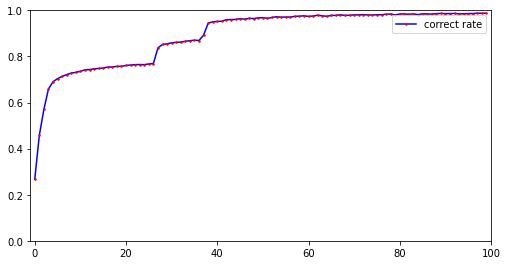

In [13]:
# figure train process
figure = plt.figure(figsize=(8,4))
ax = figure.add_axes([0.1,0.1,0.8,0.8])
ax.plot(range(len(correct_rates)),correct_rates,
       color = (0,0,1,1),marker = '.',label = 'correct rate',
        markerfacecolor=(1,0,0,1),markeredgecolor = (1,0,0,1),markersize = 3
       )
ax.set_xbound(lower=-1,upper = len(correct_rates))
ax.set_ybound(lower=0,upper=1)
plt.legend()
plt.show()

[6]


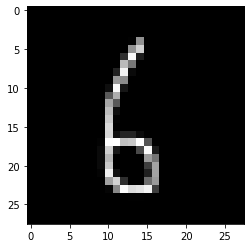

In [14]:
import cv2
test = cv2.imread('./6.png')

a = np.zeros((28,28,1))
a[:,:,0] = test[:,:,1]

plt.imshow(a,cmap = 'gray')

p_result = tf.argmax(y_,1)
r = session.run(p_result,feed_dict={x:[a]})
print(r)

In [15]:
saver = tf.train.Saver()
saver.save(session, './model/number')

'./model/number'

In [16]:
saver = tf.train.import_meta_graph('./model/number.meta')  # 先加载meta文件，具体到文件名
saver.restore(session, tf.train.latest_checkpoint('./model'))  # 加载检查点文件checkpoint，具体到文件夹即可
graph = tf.get_default_graph()  # 绘制tensorflow图

INFO:tensorflow:Restoring parameters from ./model\number


In [17]:
xs = graph.get_tensor_by_name('input/x:0')  # 获取占位符xs
ys = graph.get_tensor_by_name('input/y:0')  # 获取占位符ys
output = graph.get_tensor_by_name('prediction/output:0')

In [20]:
result_array = session.run(output, feed_dict={xs:[a]})
print(result_array)

[[1.7079900e-01 9.9835263e-05 1.0188393e-05 1.1998485e-05 4.3881359e-03
  1.9712215e-05 7.9639208e-01 1.1462588e-04 2.8149139e-02 1.5331860e-05]]


In [21]:
np.argmax(result_array,1)

array([6], dtype=int64)